
[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Training Data:  tensor([[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]])
Training Data Label:  tensor([5, 0, 4,  ..., 8, 4, 8])
Positive Data:  tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.4242, -0.4242, -0.4242],
        [ 1.0000,  0.0000,  0.0000,  ..., -0.4242, -0.4242, -0.4242],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4242, -0.4242, -0.4242],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4242, -0.4242, -0.4242],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4242, -0.4242, -0.4242],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4242, -0.4242, -0.4242]],
       device='cuda:0')
Negative Data:  tenso

100%|██████████| 1000/1000 [00:40<00:00, 24.69it/s]


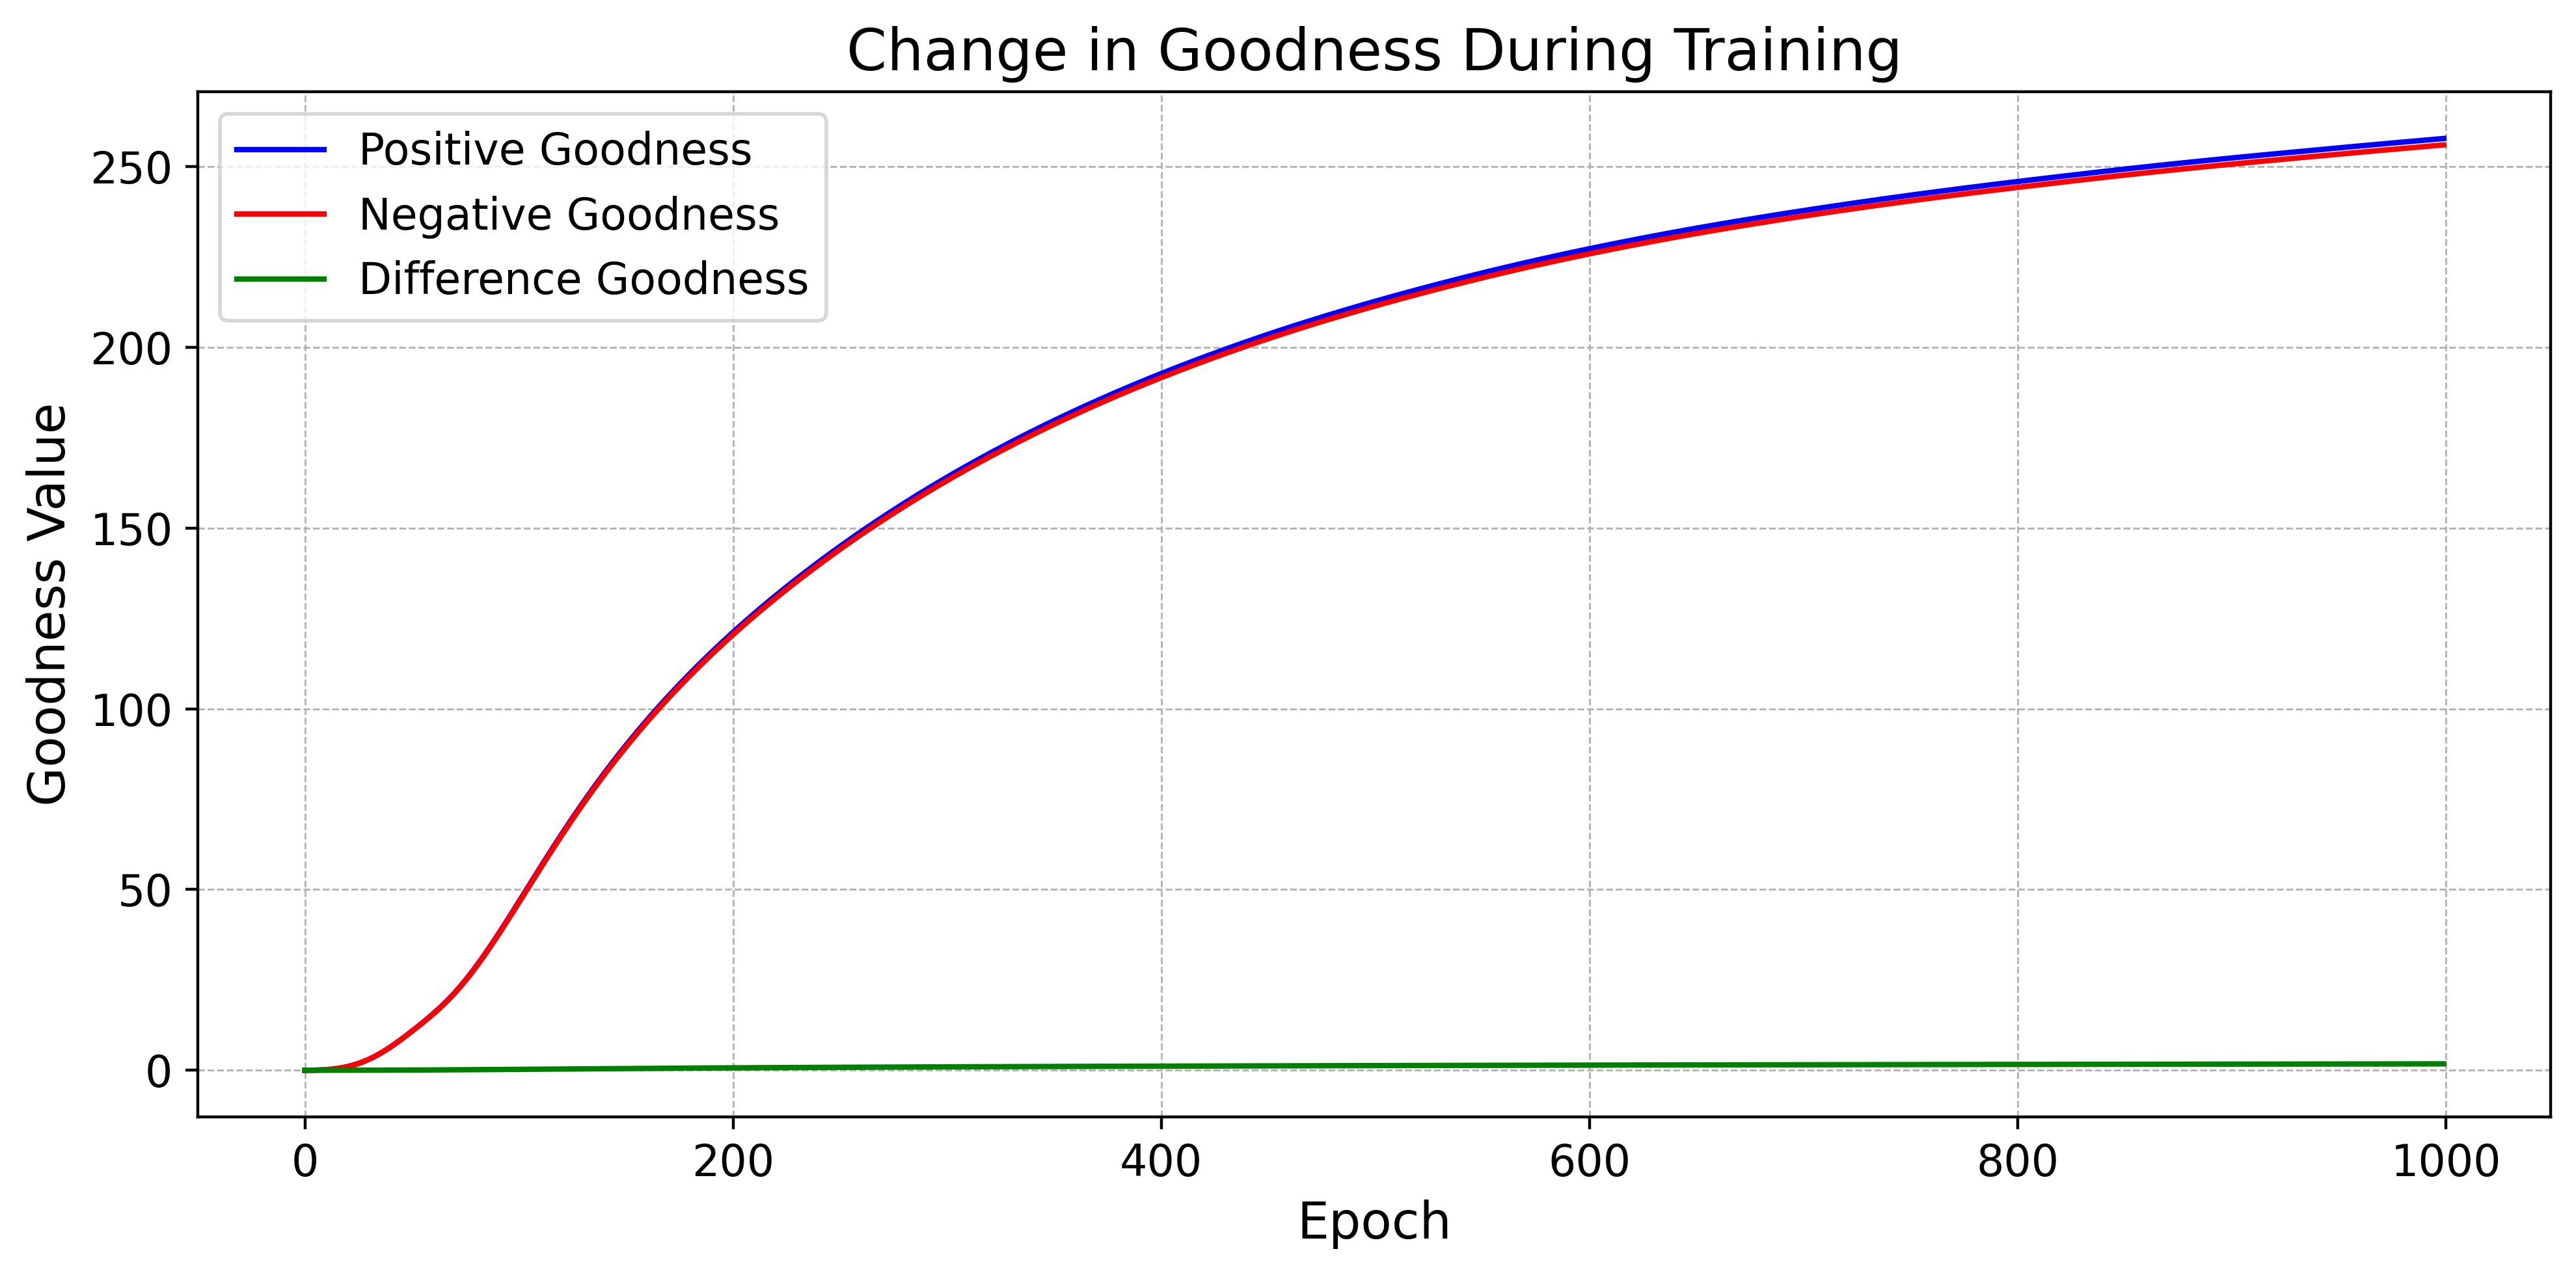

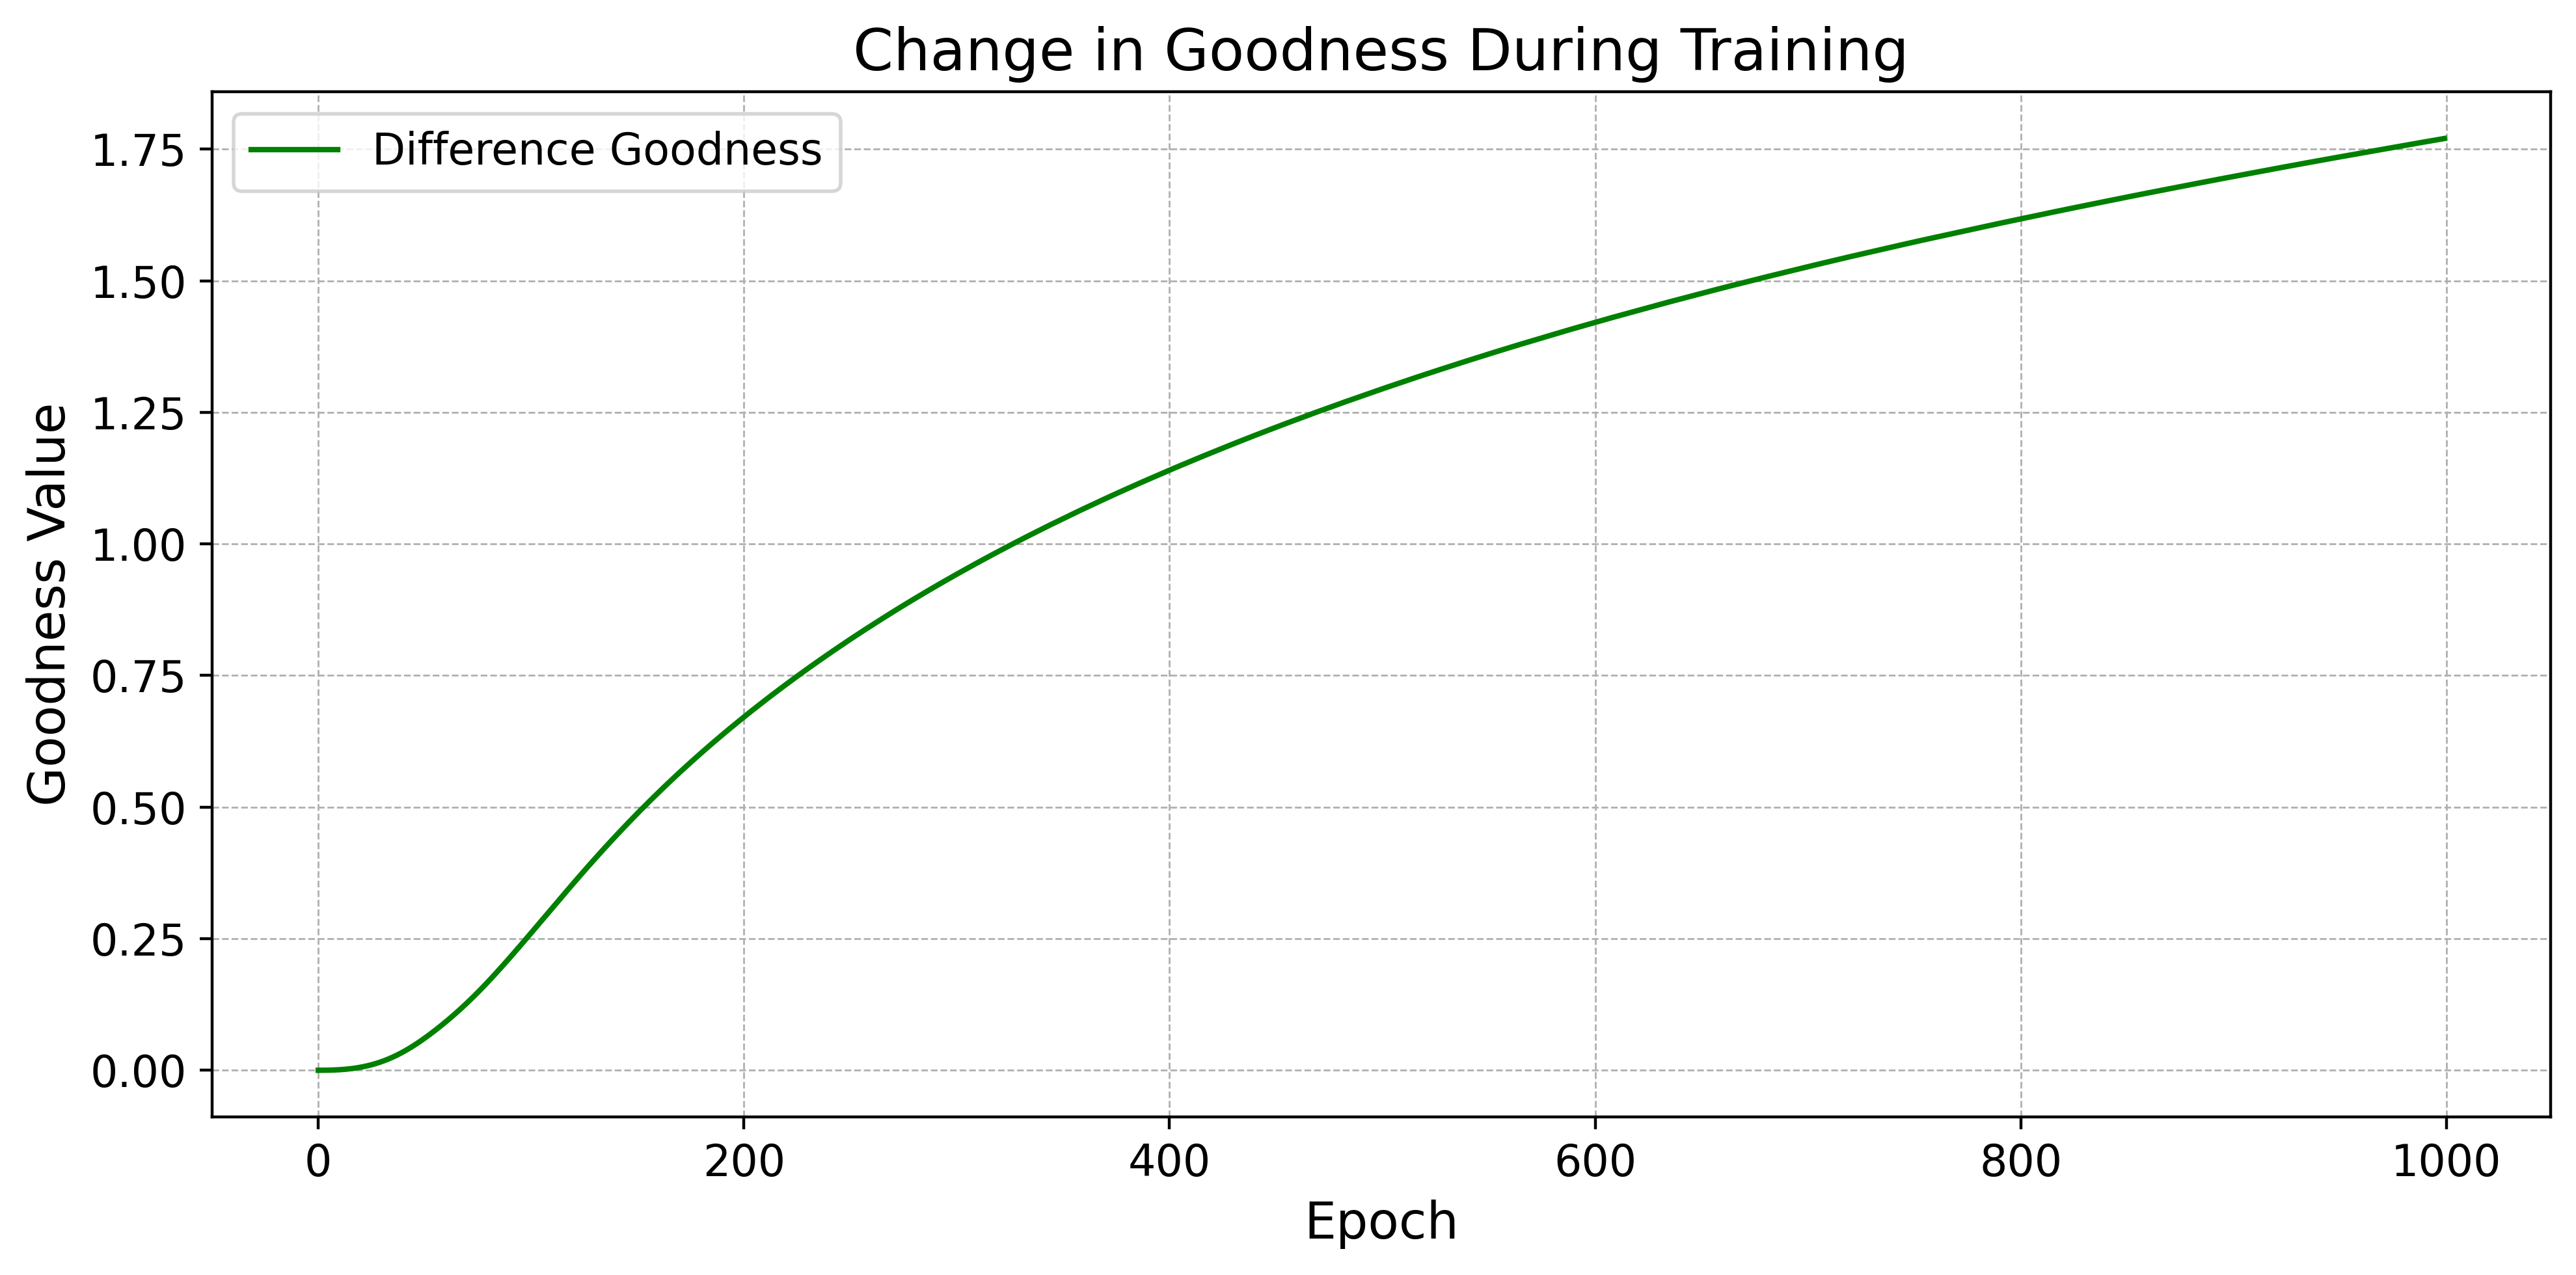

Training Layer 1 ...


100%|██████████| 1000/1000 [00:45<00:00, 22.15it/s]


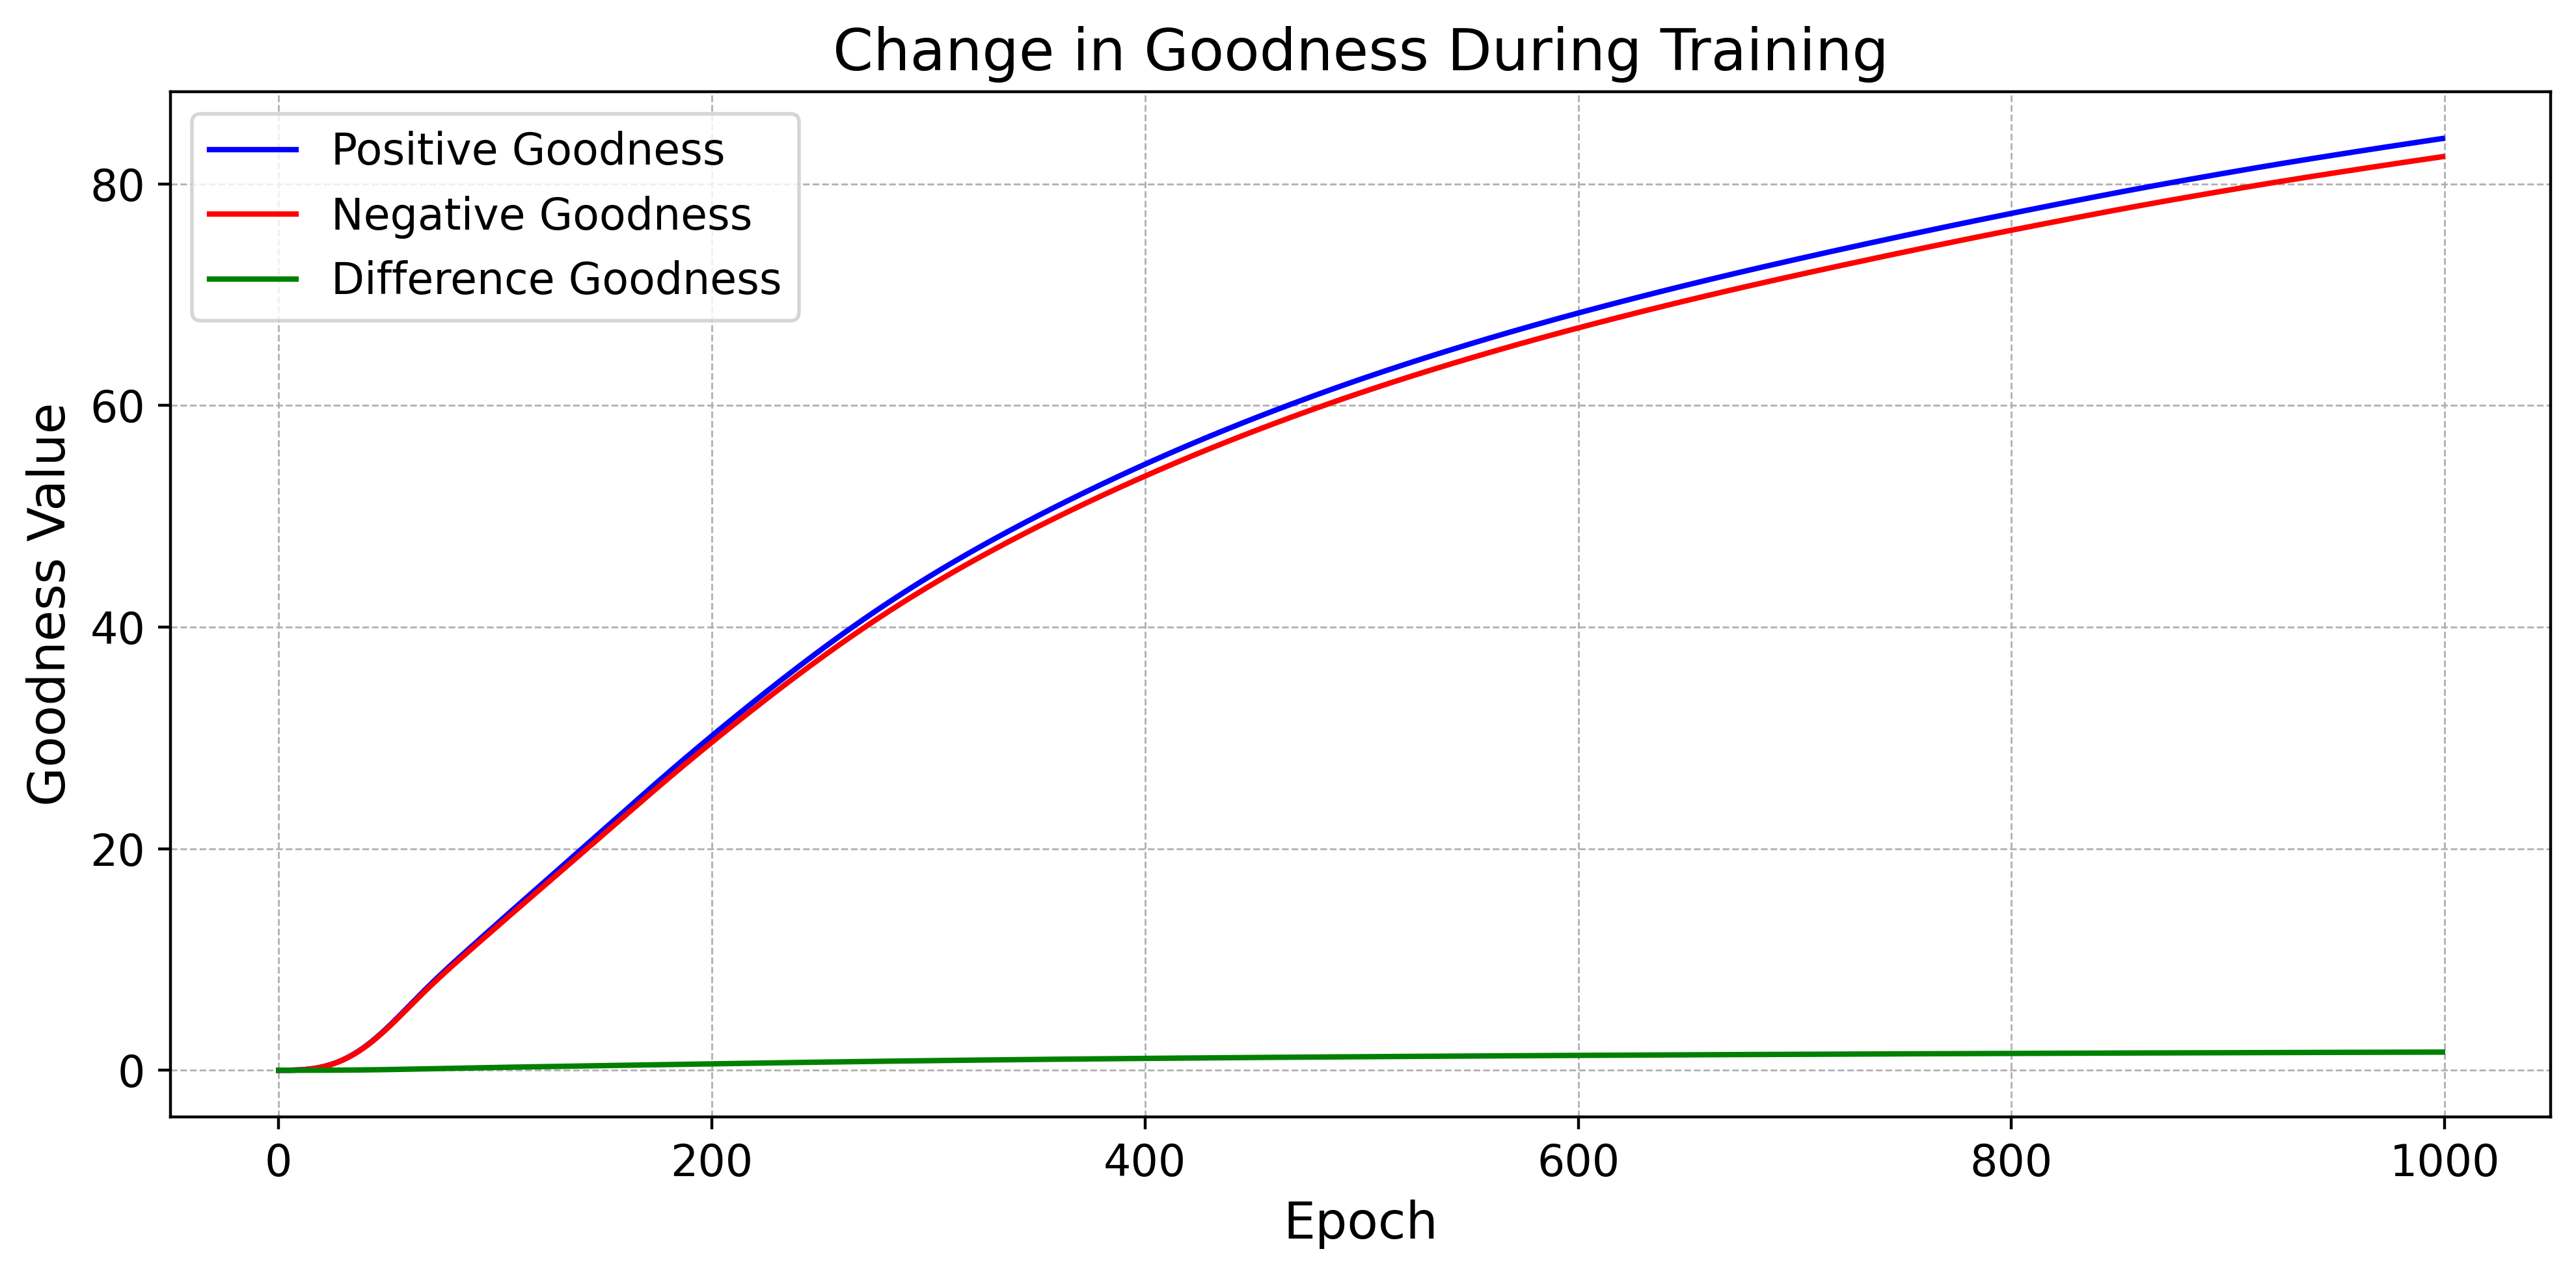

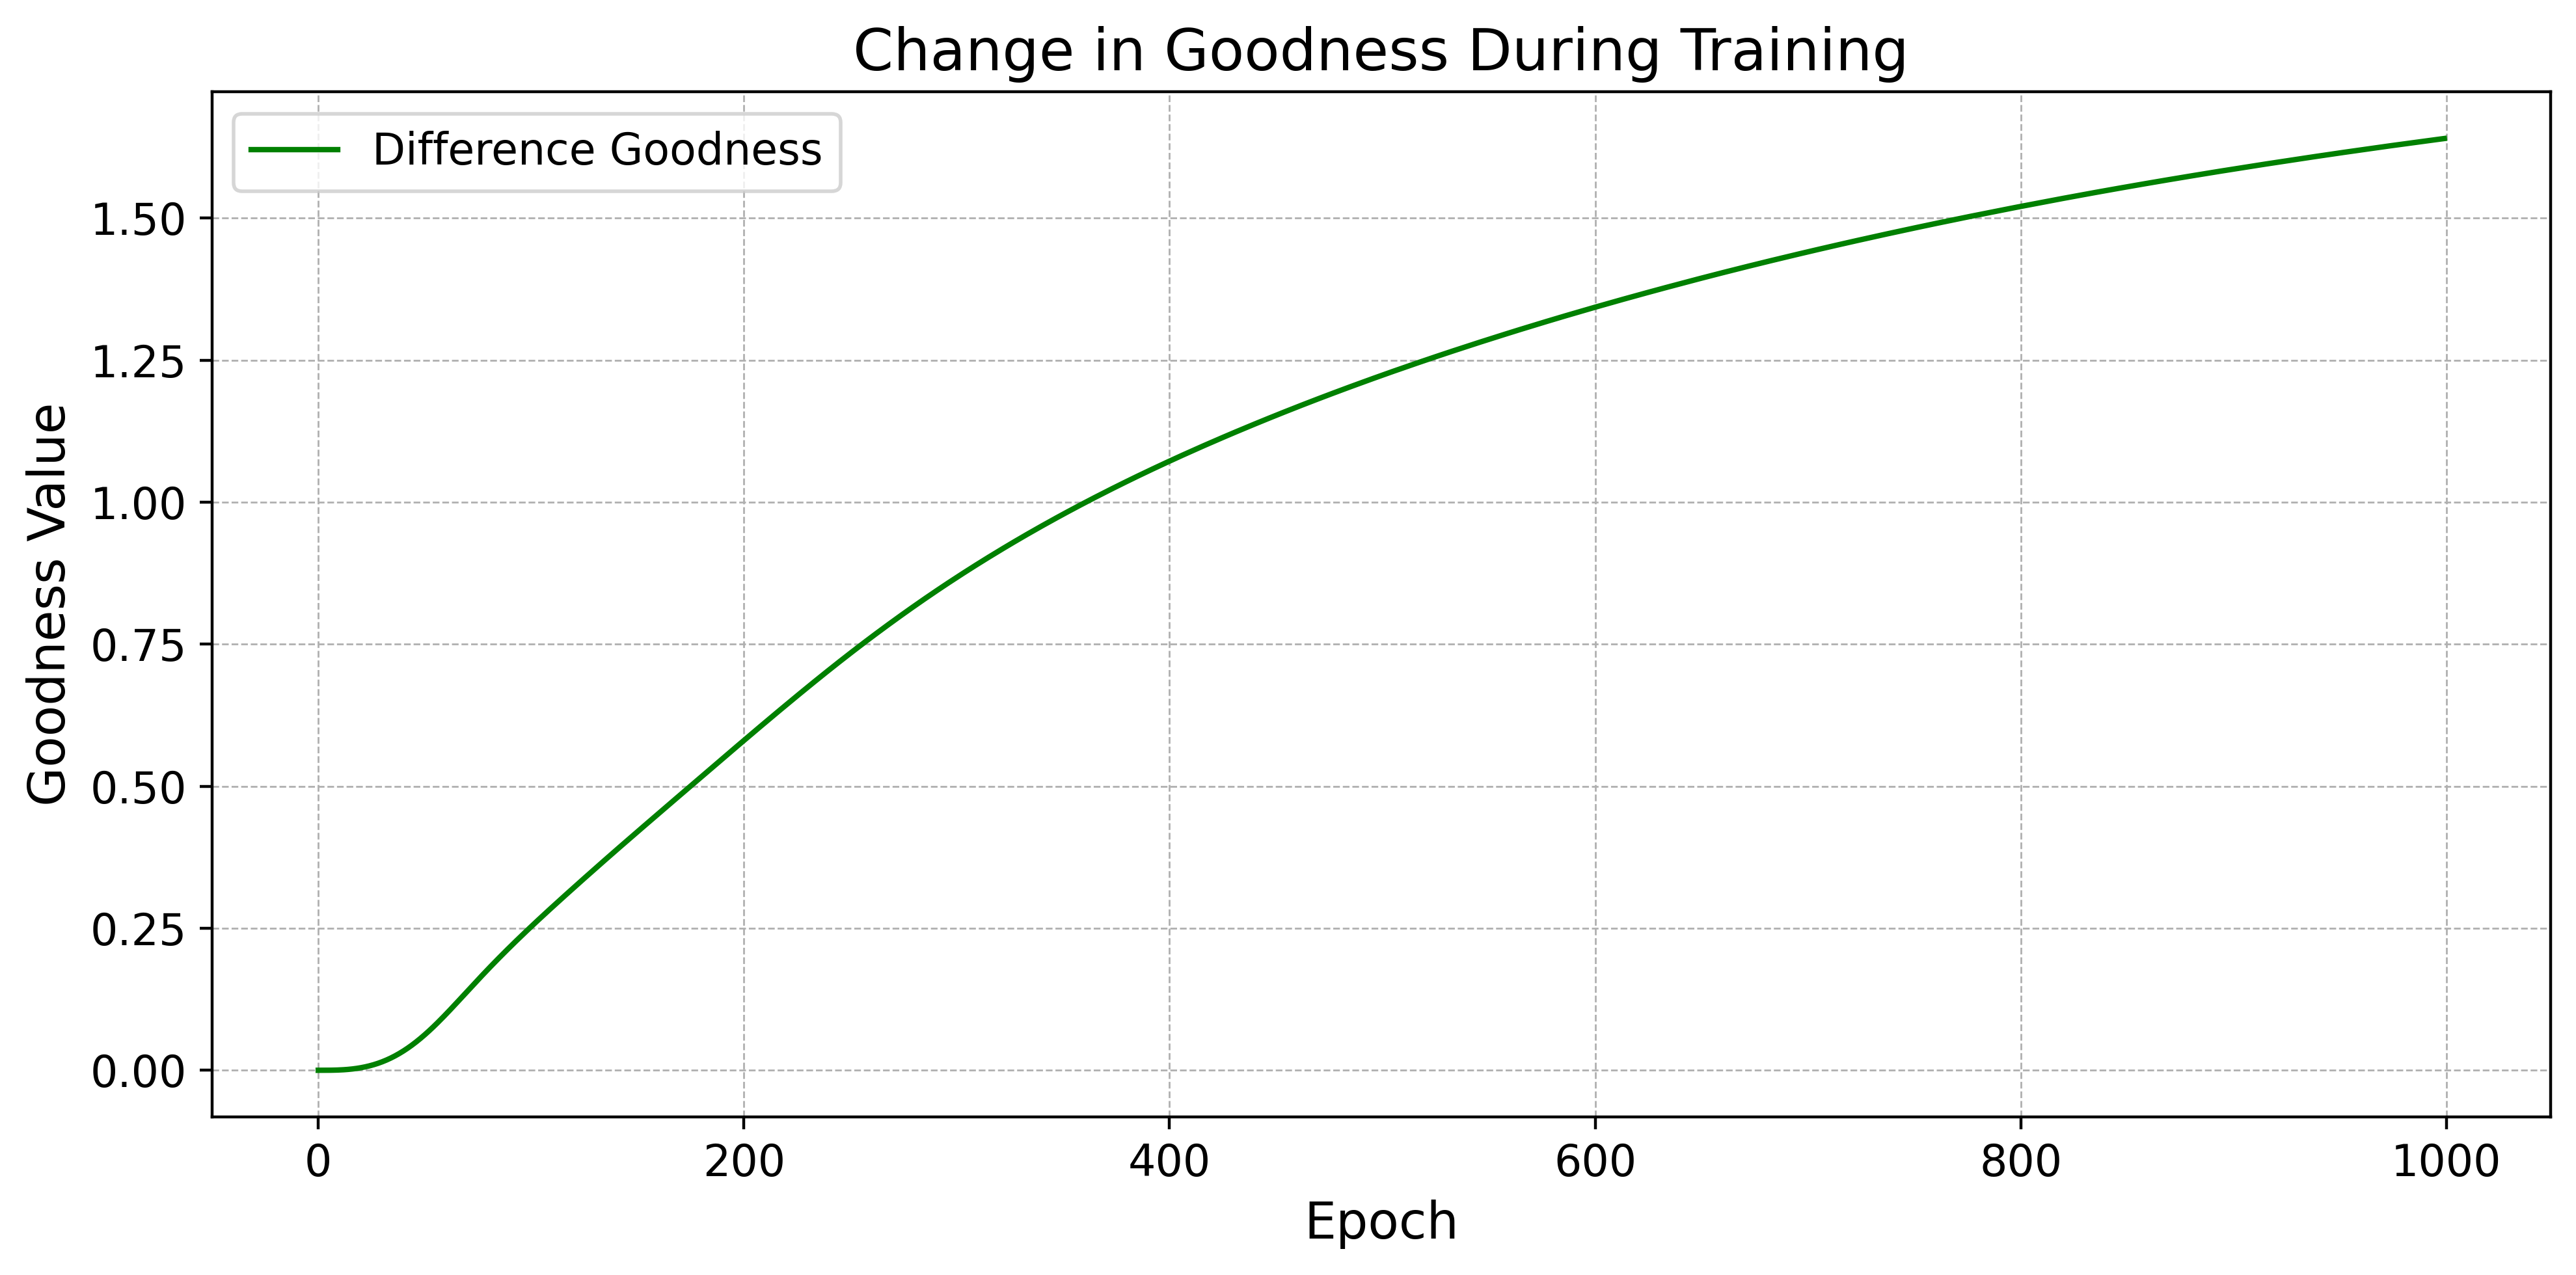

Training Accuracy:  0.9096799492835999
Testing Accuracy:  0.9111999869346619


In [4]:
!pip install tqdm
!pip install matplotlib

import random

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

import torch.nn as nn

from torch import Tensor
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam

number_of_epochs = 1000

def regularize_matrix(A, lambda_val=1e-5):
    n = A.size(0)  # Assuming A is square
    I = torch.eye(n, dtype=A.dtype, device=A.device)
    A_regularized = A + lambda_val * I
    return A_regularized

def add_noise(A, epsilon=1e-5):
    noise = (torch.randn(A.shape) * epsilon).cuda()
    return A + noise

def find_particular_solution(A, b):
    A_pinv = torch.linalg.pinv(A)  # Compute pseudoinverse
    x_p = A_pinv @ b
    return x_p

class Layer(nn.Linear):

    def __init__(self, in_features, out_features, bias=True, device=None, d_type=None, is_hinge_loss=False):
        super().__init__(in_features, out_features, bias, device, d_type)
        self.activation = torch.nn.ReLU()
        self.learning_rate = 0.01
        self.optimizer = Adam(self.parameters(), lr=self.learning_rate)
        # self.layer_weights = nn.Parameter(torch.ones(6, 800))
        self.threshold = 2.0
        self.num_of_epochs = number_of_epochs
        self.is_hinge_loss = is_hinge_loss
        
        
    def forward(self, input: Tensor) -> Tensor:
        normalized_input = input / (input.norm(2, 1, keepdim=True) + 1e-4)
        output = torch.mm(normalized_input, self.weight.T) + self.bias.unsqueeze(0)
        return self.activation(output)


    def balanced_loss(self, positive_goodness, negative_goodness, alpha=4.0):
        delta = positive_goodness - negative_goodness
        per_instance_loss = torch.log(1 + torch.exp(-alpha * delta))
        return per_instance_loss.mean()  # Averaging the loss to ensure it's a scalar


    def soft_plus_loss(self, positive_goodness, negative_goodness, is_second_phase=False):
        if is_second_phase:
            threshold = self.threshold * 2
        else:
            threshold = self.threshold
        return torch.log(1 + torch.exp(torch.cat([
            -positive_goodness + threshold,
            negative_goodness - threshold]))).mean()



    def plot_goodness(self, positive_goodness_history, negative_goodness_history,
                      positive_unaltered_goodness_history, negative_unaltered_goodness_history):
        epochs = range(1, self.num_of_epochs + 1)

        plt.figure(figsize=(14, 7))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, positive_goodness_history, label='Altered Positive Goodness')
        plt.plot(epochs, positive_unaltered_goodness_history, label='Unaltered Positive Goodness')
        plt.legend()
        plt.title('Positive Goodness Comparison Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Goodness')

        plt.subplot(2, 1, 2)
        plt.plot(epochs, negative_goodness_history, label='Altered Negative Goodness')
        plt.plot(epochs, negative_unaltered_goodness_history, label='Unaltered Negative Goodness')
        plt.legend()
        plt.title('Negative Goodness Comparison Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Goodness')

        plt.tight_layout()
        plt.show()
        
    def plot_goodness(self, positive_goodness, negative_goodness, difference):
        plt.figure(figsize=(10, 5), dpi=400)  # Higher dpi for better resolution
        plt.plot(positive_goodness, label='Positive Goodness', color='b')
        plt.plot(negative_goodness, label='Negative Goodness', color='r')
        plt.plot(difference, label='Difference Goodness', color='g')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Goodness Value', fontsize=14)
        plt.title('Change in Goodness During Training', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tick_params(labelsize=12)
        plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
        plt.savefig('Goodness_Tracking.pdf', format='pdf')  # Save as PDF
        plt.show()

    def plot_difference(self, difference):
        plt.figure(figsize=(10, 5), dpi=400)
        plt.plot(difference, label='Difference Goodness', color='g')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Goodness Value', fontsize=14)
        plt.title('Change in Goodness During Training', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig('Difference_Goodness.pdf', format='pdf')
        plt.show()
        
        
    def train_layer(self, positive_input, negative_input, layer_num):
        positive_goodness_history = []
        negative_goodness_history = []
        difference_history = []
        for _ in tqdm(range(self.num_of_epochs)):
            positive_output = self.forward(positive_input)  # Shape: [batch_size, 500]
            negative_output = self.forward(negative_input)
    
            positive_goodness = (positive_output.pow(2)).mean(1)  # Shape: [batch_size]
            negative_goodness = (negative_output.pow(2)).mean(1)
            
            positive_goodness_history.append(positive_goodness.mean().item())
            negative_goodness_history.append(negative_goodness.mean().item())
            difference_history.append(positive_goodness.mean().item() - negative_goodness.mean().item())
            if self.is_hinge_loss:
                loss = self.soft_plus_loss(positive_goodness, negative_goodness)
            else:
                loss = self.balanced_loss(positive_goodness, negative_goodness)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        # layer_weight_row = Layer.layer_weights[layer_num, :]
        # layer_weight_four_row = Layer.layer_weights_four[layer_num, :]
        # positive_output = self.forward(positive_input)
        # negative_output = self.forward(negative_input)
        
        # if layer_num == 0:
        #     # Layer.layer_values_one = torch.cat((positive_output.pow(2) * layer_weight_row + positive_output.pow(4) * layer_weight_four_row, negative_output.pow(2) * layer_weight_row + negative_output.pow(4) * layer_weight_four_row), dim=0)
        #     # 
        #     new_values_one = (positive_output.pow(2) * layer_weight_row + positive_output.pow(4) * layer_weight_four_row).mean(1).detach().clone()
        #     print(f"SHAPE: {new_values_one.shape}")
        #     new_values_two = (negative_output.pow(2) * layer_weight_row + negative_output.pow(4) * layer_weight_four_row).mean(1).detach().clone()
        #     Layer.layer_one_sum = torch.cat((new_values_one, new_values_two), dim=0)
        #     
        # 
        #     
        # else:
        #     # Layer.layer_values_two = torch.cat((positive_output.pow(2) * layer_weight_row + positive_output.pow(4) * layer_weight_four_row, negative_output.pow(2) * layer_weight_row + negative_output.pow(4) * layer_weight_four_row), dim=0)
        #     
        #     new_values_one = (positive_output.pow(2) * layer_weight_row + positive_output.pow(4) * layer_weight_four_row).mean(1).detach().clone()
        #     new_values_two = (negative_output.pow(2) * layer_weight_row + negative_output.pow(4) * layer_weight_four_row).mean(1).detach().clone()
        #     Layer.layer_two_sum = torch.cat((new_values_one, new_values_two), dim=0)
        #     
        self.plot_goodness(positive_goodness_history, negative_goodness_history, difference_history)
        self.plot_difference(difference_history)
        return self.forward(positive_input).detach(), self.forward(negative_input).detach()


class Network(nn.Module):

    def __init__(self, dimension_configs):
        super().__init__()
        self.layers = []
        #self.layer_weights = nn.Parameter(torch.ones(2))
        for i in range(len(dimension_configs) - 1):
            self.layers += [Layer(dimension_configs[i], dimension_configs[i + 1]).cuda()]

    def mark_data(self, data, label):
        marked_data = data.clone().cuda()
        marked_data[:, :10] = 0
        marked_data[torch.arange(marked_data.size(0)), label] = 1
        return marked_data
# Layer.layer_final_weights[layer_num]
    def predict(self, input_data):
        goodness_per_label = []
        for label in range(10):
            marked_data = self.mark_data(input_data, label)
            goodness = []
            for layer_num, layer in enumerate(self.layers):
                marked_data = layer(marked_data)
             

                goodness_value = ((marked_data.pow(2)) * 1).mean(1)
                goodness.append(goodness_value)
            goodness_per_label.append(torch.sum(torch.stack(goodness), dim=0).unsqueeze(1))
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(dim=1)

    def train_network(self, positive_goodness, negative_goodness):
        #optimizer = Adam(self.parameters(), lr=0.001)
        goodness_pos, goodness_neg = positive_goodness, negative_goodness
        for i, layer in enumerate(self.layers):
            print('Training Layer', i, '...')
            goodness_pos, goodness_neg = layer.train_layer(goodness_pos, goodness_neg, i)
            
        # print(Layer.layer_one_sum)
        # data_one = Layer.layer_one_sum
        # data_two = Layer.layer_two_sum
        # 
        # combined_output = torch.cat((data_one.unsqueeze(1), data_two.unsqueeze(1)), dim=1)
        # positive_labels = torch.full((60000, 1), 9999999, dtype=torch.float32)
        # negative_labels = torch.full((60000, 1), -9999999, dtype=torch.float32)
        # labels = torch.cat((positive_labels, negative_labels), dim=0).cuda()
        # 
        # A = combined_output.cuda()
        # b = labels.cuda()
        # x = torch.linalg.pinv(A) @ b
        # 
        # new_weights = x.reshape(2).cuda()
        # print(f"NEW WEIGHTS: {new_weights}")
        # Layer.layer_final_weights = new_weights.clone()
        # 
        # print(f"FINAL WEIGHTS: {Layer.layer_final_weights}")
        # combined_output = torch.cat((Layer.layer_values_one, Layer.layer_values_two), dim=1).cuda()
        # positive_labels = torch.full((60000, 1), 9999999, dtype=torch.float32)
        # negative_labels = torch.zeros((60000, 1), dtype=torch.float32)
        # labels = torch.cat((positive_labels, negative_labels), dim=0).cuda()
        # A = combined_output.cuda()
        # b = labels.cuda()
        # x = torch.linalg.pinv(A) @ b
        # 
        # new_weights = x.reshape(1, 800).cuda()
        # 
        # Layer.layer_final_weights.data[0, :] = new_weights[0, :400].clone()
        # Layer.layer_final_weights.data[1, :] = new_weights[0, 400:800].clone()


def load_CIFAR10_data(train_batch_size=30000, test_batch_size=6000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        CIFAR10('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        CIFAR10('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_FashionMNIST_data(train_batch_size=60000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.2860,), (0.3530,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        FashionMNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        FashionMNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader

def load_MNIST_data(train_batch_size=50000, test_batch_size=10000):
    data_transformation = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    training_data_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=data_transformation),
        batch_size=train_batch_size,
        shuffle=False
    )

    testing_data_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=data_transformation),
        batch_size=test_batch_size,
        shuffle=False
    )

    return training_data_loader, testing_data_loader


def create_positive_data(data, label):
    positive_data = data.clone()
    positive_data[:, :10] = 0.0

    for i in range(positive_data.shape[0]):
        positive_data[i][label[i]] = 1.0

    return positive_data


def create_negative_data(data, label, seed=None):
    if seed is not None:
        random.seed(seed)

    negative_data = data.clone()
    negative_data[:, :10] = 0.0

    for i in range(negative_data.shape[0]):
        possible_answers = list(range(10))
        possible_answers.remove(label[i])
        false_label = random.choice(possible_answers)
        negative_data[i][false_label] = 1.0

    return negative_data


def prepare_data():
    torch.manual_seed(1234)
    training_data_loader, testing_data_loader = load_MNIST_data()

    training_data, training_data_label = next(iter(training_data_loader))

    testing_data, testing_data_label = next(iter(testing_data_loader))
    testing_data, testing_data_label = testing_data.cuda(), testing_data_label.cuda()

    print(f"Training Data: ", training_data)
    print(f"Training Data Label: ", training_data_label)

    training_data, training_data_label = training_data.cuda(), training_data_label.cuda()

    positive_data = create_positive_data(training_data, training_data_label)
    print(f"Positive Data: ", positive_data)

    negative_data = create_negative_data(training_data, training_data_label, seed=1234)
    print(f"Negative Data: ", negative_data)

    return positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label


if __name__ == "__main__":
    torch.cuda.empty_cache()
    torch.manual_seed(1234)
    positive_data, negative_data, training_data, training_data_label, testing_data, testing_data_label = prepare_data()
    network = Network([784, 1000, 1000]).cuda() #3072
    network.train_network(positive_data, negative_data)

    print("Training Accuracy: ", network.predict(training_data).eq(training_data_label).float().mean().item())

    print("Testing Accuracy: ", network.predict(testing_data).eq(testing_data_label).float().mean().item())